In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def get_dfs(experiment_number: int, pos_number: int) -> pd.DataFrame:
    log_df = pd.read_csv(f'results/experiment_{experiment_number}/pos{pos_number}_logs.csv', sep=';', skiprows=5, names=['time','side','closest_point_dist','relative_dist','angular_vel','linear_vel'])
    odom_df = pd.read_csv(f'results/experiment_{experiment_number}/pos{pos_number}_odometry.csv', sep=',', names=['s','ns','x', 'y','theta'])
    log_df['time'] = log_df['time'] - log_df['time'][0]
    return log_df, odom_df

log_df, odom_df = get_dfs(1, 1)
log_df.head()

,time,side,closest_point_dist,relative_dist,angular_vel,linear_vel
0,0.000000,right,2.7554,-1.7554,-4.0911,0.2444
1,0.002789,right,2.7554,-1.7554,-4.0911,0.2444
2,0.018969,right,2.7554,-1.7554,-4.0911,0.2444
3,0.022429,right,2.7554,-1.7554,-4.0911,0.2444
4,0.032741,right,2.7555,-1.7555,-4.0912,0.2444


In [3]:
odom_df.head()

,s,ns,x,y,theta
0,73,261000000,-0.449587,0.002030,-29.772139
1,73,271000000,-0.449587,0.002030,-29.772167
2,73,281000000,-0.449585,0.002031,-29.772144
3,73,291000000,-0.449547,0.001952,-29.772018
4,73,301000000,-0.449432,0.001719,-29.771799


In [4]:
def get_lap_time(df: pd.DataFrame) -> float:
    return df['time'][len(df['time'])-1] - df['time'][0]

In [5]:
def get_metrics_for_experiments(experiments: [int], num_pos: int) -> None:
    for experiment in experiments:
        lap_times = []
        avg_linear_velocity = []
        avg_angular_velocity = []
        relative_distance = []

        for i in range(1, num_pos+1):
            log_df, odom_df = get_dfs(experiment, i)
            lap_times.append(get_lap_time(log_df))
            avg_linear_velocity.append(np.mean(log_df['linear_vel']))
            avg_angular_velocity.append(np.mean(abs(log_df['angular_vel'])))
            relative_distance.append(np.mean(abs(log_df['relative_dist'])))
            
        print(f'Experiment {experiment}: {np.mean(lap_times):.4f} +- {np.std(lap_times):4f} s, {np.mean(avg_linear_velocity):.4f} +- {np.std(avg_linear_velocity):.4f} m/s, {np.mean(avg_angular_velocity):.4f} +- {np.std(avg_angular_velocity):.4f} rad/s, {np.mean(relative_distance):.4f} +- {np.std(relative_distance):.4f} m')
get_metrics_for_experiments([1,2,3,4,5,6], 3)

Experiment 1: 81.5782 +- 4.501095 s, 0.9547 +- 0.0125 m/s, 0.4643 +- 0.0873 rad/s, 0.3128 +- 0.0393 m
Experiment 2: 97.1653 +- 6.363813 s, 0.8896 +- 0.0104 m/s, 0.8579 +- 0.1289 rad/s, 0.1790 +- 0.0312 m
Experiment 3: 44.5429 +- 1.644982 s, 0.9428 +- 0.0082 m/s, 0.4909 +- 0.0363 rad/s, 0.2748 +- 0.0144 m
Experiment 4: 81.9628 +- 6.534688 s, 0.9325 +- 0.0125 m/s, 0.5692 +- 0.0960 rad/s, 0.3394 +- 0.0394 m
Experiment 5: 100.5714 +- 10.255103 s, 0.9509 +- 0.0039 m/s, 0.5304 +- 0.0171 rad/s, 0.1704 +- 0.0069 m
Experiment 6: 89.7045 +- 6.979305 s, 0.9506 +- 0.0141 m/s, 0.4934 +- 0.0935 rad/s, 0.3273 +- 0.0484 m


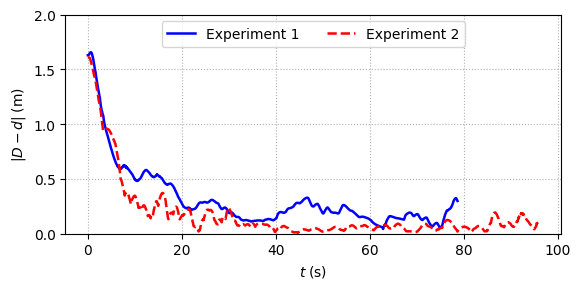

In [6]:
def plot_stability_for_experiments(experiments: [int], num_pos: int, colors: [str], linestyles: [str]) -> None:
    plt.figure(figsize=(6, 3))

    def plot_stability(dfs: [pd.DataFrame], label: str, color='blue', linestyle='-') -> None:
        average_relative_dist_df = dfs[0].copy()
        average_relative_dist_df['relative_dist'] = sum([abs(dfs[i]['relative_dist']) for i in range(len(dfs))]) / len(dfs)

        plt.plot(average_relative_dist_df['time'], average_relative_dist_df['relative_dist'],
            linestyle=linestyle,
            linewidth=1.8,
            color=color,
            label=label
        )

    for experiment, color, linestyle in zip(experiments, colors, linestyles):
        dfs_to_plot = [get_dfs(experiment, i)[0] for i in range(1, num_pos+1)]
        plot_stability(dfs_to_plot, label=f'Experiment {experiment}', color=color, linestyle=linestyle)

    plt.xlabel(r'$t\;(\text{s})$')
    plt.ylabel(r'$|D-d|\;(\text{m})$')
    plt.ylim(0, 2)
    plt.grid(linestyle='dotted')
    plt.legend(ncol=2, loc=9) # 9 means top center
    plt.tight_layout()

plot_stability_for_experiments([1, 2, 4], 3, colors=['blue', 'red'], linestyles=['-', '--'])
plt.savefig('relative_dist.pdf', dpi=500)

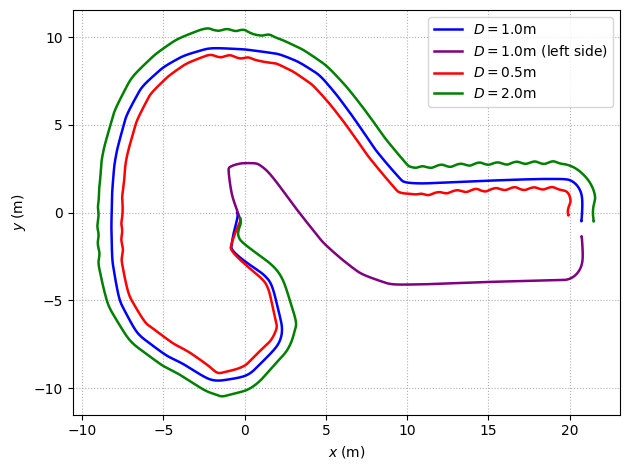

In [9]:
#plt.figure(figsize=(6, 4))
def plot_odometry(df: pd.DataFrame, color:str ='blue', linestyle: str='-', label: str ='') -> None:
    plt.plot(df['x'], df['y'], color=color, linewidth=1.8, linestyle=linestyle, label=label)

plot_odometry(odom_df, linestyle='-', label=r'$D = 1.0 \text{m}$')
plot_odometry(get_dfs(3, 1)[1], color='purple', linestyle='-', label=r'$D = 1.0 \text{m}$ (left side)')
plot_odometry(get_dfs(4, 1)[1], color='red', linestyle='-', label=r'$D = 0.5 \text{m}$')
plot_odometry(get_dfs(5, 1)[1], color='green', linestyle='-', label=r'$D = 2.0 \text{m}$')

plt.xlabel(r'$x\;(\text{m})$')
plt.ylabel(r'$y\;(\text{m})$')
plt.grid(linestyle='dotted')
plt.legend(ncol=1, loc='upper right')
plt.tight_layout()
plt.savefig('odometry.pdf', dpi=500)

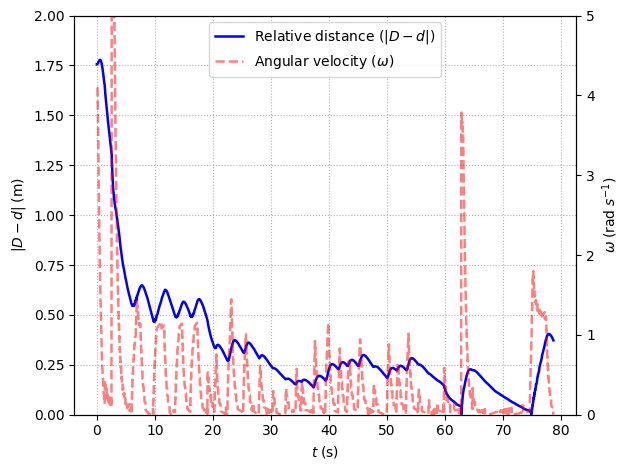

In [8]:

#plt.figure(figsize=(6, 4))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ln1 = ax1.plot(log_df['time'], abs(log_df['relative_dist']),
        linestyle='-',
        linewidth=1.8,
        color='blue',
        label='Relative distance ($|D-d|$)'
    )


ln2 = ax2.plot(log_df['time'], abs(log_df['angular_vel']),
        linestyle='--',
        linewidth=1.8,
        color='red',
        label=r'Angular velocity ($\omega$)',
        alpha=0.5
    )

ax1.set_xlabel(r'$t\;(\text{s})$')
ax1.set_ylabel(r'$|D-d|\;(\text{m})$')
ax1.set_ylim(0, 2)
ax1.grid(linestyle='dotted')

lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=9)

ax2.set_ylim(0, 5)
ax2.set_ylabel(r'$\omega\;(\text{rad}\;s^{-1})$')

plt.tight_layout()
plt.savefig('relative_dist_and_angular_vel.pdf', dpi=500)